# Classify Urban Areas

In [1]:
import os
import warnings
from pprint import pprint
import descarteslabs as dl
import matplotlib.pyplot as plt
from matplotlib import colors
from osgeo import gdal
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

## Define Raster Datasets and Study Area

The ```Metadata API``` allows you to search our imagery catalog. Alternatively, you can identify images in Viewer.

In [47]:
shape = dl.places.shape('burundi')

In [ ]:
feature_collection = dl.metadata.search(products=['landsat:LC08:01:RT:TOAR','landsat:LC08:01:T1:TOAR'], 
                                        start_time='2017-05-01',
                                        end_time='2017-05-31', 
                                        cloud_fraction=.01,
                                        place=shape)


In [18]:
north_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172062_20170701_20170701_01_RT_v1'
south_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172063_20170701_20170701_01_RT_v1'
north_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173062_20170606_20170616_01_T1_v1'
south_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173063_20170606_20170616_01_T1_v1'
ids = [south_east,south_west, north_east,north_west]

## Visualize selected Images
It is good as a sanity check to view the imagery we've selected.

In [20]:
viz_arr, viz_meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Byte',
    resolution=60,
    cutline=shape['geometry']
)

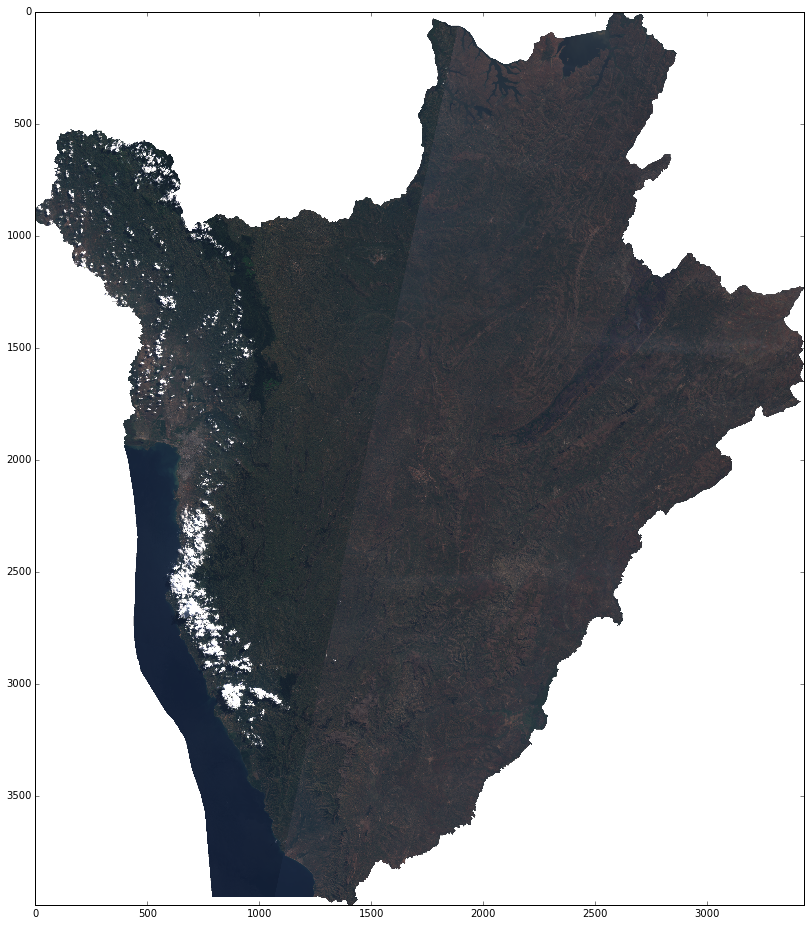

In [21]:
plt.figure(figsize=[16,16])
plt.imshow(viz_arr)

## Prepare raster data for analysis
We add a the correct coordinate system, bounding box, and resolution so the urban land cover classification will match our Night Light image.

In [23]:
arr, meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Float32',
    resolution=351.263936238588940,
    resampler='cubic',
    srs = "EPSG:32636",
    bounds=(55210.738, -494687.129, 261010.738, -255587.129)
)

We also must extract and validate metadata information for the image before classification.

In [28]:
rows, cols, n_bands = clipped_arr.shape 
geo_transform = clipped_meta['geoTransform']
proj = 'PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]'


print(rows,cols,n_bands)

(681, 586, 4)


### Write helper functions to rasterize vector data via gdal
We need a library of functions to rasterize our training data.

In [40]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    print
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

### Classify urban areas using predefined training data
Define training datasets:

In [41]:
output_fname = "data/urban_other.tiff"
train_data_path = "data/training/urban"

In [44]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
print("The class are {} and {}.".format(classes[0],classes[1]))
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = clipped_arr[is_train]

The class are urban and non_urban.



### Train model

In [48]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
n_samples = rows*cols
flat_pixels = clipped_arr.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

In [36]:
write_geotiff(output_fname, classification, geo_transform, proj)

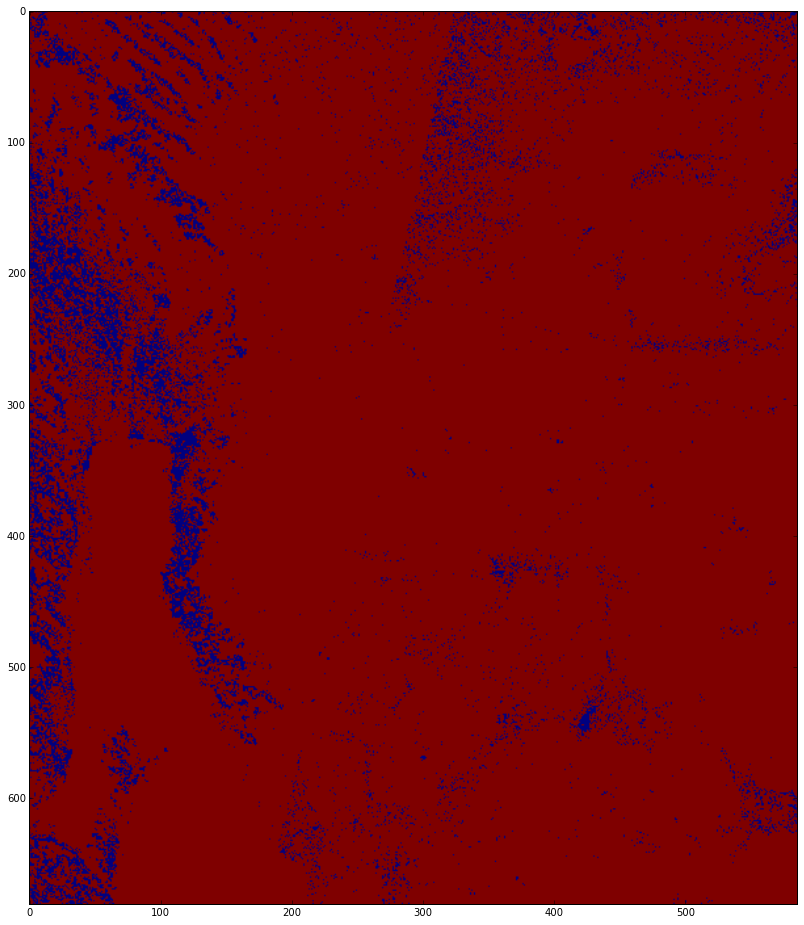

In [38]:
from matplotlib import pyplot as plt

plt.figure(figsize=[16,16])
plt.imshow(classification)

### Upload Classification to Platform
First, we extract a few pieces of metadata from the image.

In [50]:
band = classification
print("Band Type={}".format(type(band[0][0])))
      
min = np.ndarray.max(band)
max = np.ndarray.min(classification)
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))


Band Type=<type 'numpy.float64'>
Min=2.000, Max=1.000


In [2]:
from descarteslabs.client.services import Catalog

In [4]:
Catalog().add_product('Urban_Burundi', 
                      title='Urban_Burundi', 
                      description='Urban areas identified using the random forest .'
                     )

{u'data': {u'attributes': {u'description': u'Urban areas identified using the random forest .',
   u'read': [],
   u'title': u'Urban_Burundi'},
  u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:Urban_Burundi',
  u'meta': {u'owner': {u'email': None,
    u'name': u'Karla King',
    u'uuid': u'google-oauth2|101598335967461239621'},
   u'owner_type': u'user'},
  u'type': u'product'}}

In [5]:
Catalog().add_band(product_id='7294028cc01114d89a473cf055d29dc5cd5ffe88:Urban_Burundi', name='urban', srcband=1, nbits=64,dtype='Float64',type='class',data_range=[1.000,2.000],colormap_name='magma')


{u'data': {u'attributes': {u'colormap_name': u'magma',
   u'data_range': [1.0, 2.0],
   u'default_range': None,
   u'dtype': u'Float64',
   u'jpx_layer': 0,
   u'name': u'urban',
   u'nbits': 64,
   u'nodata': None,
   u'read': [],
   u'res_factor': 1,
   u'srcband': 1,
   u'srcfile': 0,
   u'type': u'class'},
  u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:Urban_Burundi:urban',
  u'meta': {u'owner': {u'email': None,
    u'name': u'Karla King',
    u'uuid': u'google-oauth2|101598335967461239621'},
   u'owner_type': u'user'},
  u'relationships': {u'product': {u'data': {u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:Urban_Burundi',
     u'type': u'product'}}},
  u'type': u'band'}}

In [7]:
image_on_disc = '/Users/karlaking/descarteslabs-code/poverty-predictor/data/derived/urban_other.tiff'
acquired_date = '2018-04-05'

Catalog().upload_image(image_on_disc,
                       '7294028cc01114d89a473cf055d29dc5cd5ffe88:Urban_Burundi',  
                       acquired=acquired_date)